In [ ]:
#Import and load libraries
!pip install lime
!pip install fairlearn
!pip install transformers accelerate
!pip install transformers accelerate bitsandbytes
!pip install --upgrade tensorflow
!pip install --upgrade tf_keras
!pip install --upgrade transformers
!pip install --upgrade shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from lime.lime_tabular import LimeTabularExplainer
from sklearn.utils.class_weight import compute_sample_weight
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer, AutoModelForCausalLM
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, DemographicParity, GridSearch
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from fairlearn.preprocessing import CorrelationRemover
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import shap
import random
import lime
import lime.lime_tabular
import torch
import joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1cb641c98a4232edaec56bb29ef94263fc1591ba1d5d49bb34c42d9e330645e6
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path="/content/drive/MyDrive/NCUR"
if os.path.exists(path):
  files=[file for file in os.listdir(path) if not file.startswith('.')]
  for file in files:
    print(file)
else:
  print("Path doesn't exist")

adult.csv
compas-scores-two-years-violent.csv


In [ ]:
# Load each dataset separately
#This dataset will be on the COMPAS dataset
df_compas = pd.read_csv('/content/drive/MyDrive/NCUR/compas-scores-two-years-violent.csv')
df_compas.head()


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,two_year_recid.1
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,1
2,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0,0
3,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,2013-03-26,NaN,NaN,2,0,1102,0,0,0
4,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0,0


In [ ]:
#Clean the COMPAS dataset
df_compas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4743 entries, 0 to 4742
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       4743 non-null   int64  
 1   name                     4743 non-null   object 
 2   first                    4743 non-null   object 
 3   last                     4743 non-null   object 
 4   compas_screening_date    4743 non-null   object 
 5   sex                      4743 non-null   object 
 6   dob                      4743 non-null   object 
 7   age                      4743 non-null   int64  
 8   age_cat                  4743 non-null   object 
 9   race                     4743 non-null   object 
 10  juv_fel_count            4743 non-null   int64  
 11  decile_score             4743 non-null   int64  
 12  juv_misd_count           4743 non-null   int64  
 13  juv_other_count          4743 non-null   int64  
 14  priors_count            

In [ ]:
df_compas.describe(include='all')

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,two_year_recid.1
count,4743.000000,4743,4743,4743,4743,4743,4743,4743.000000,4743,4743,...,4743,4743,4534,4534,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000,4743.000000
unique,NaN,4721,2114,2897,586,2,3978,NaN,3,6,...,3,586,1003,1012,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,james adams,michael,williams,2013-09-23,Male,1989-08-31,NaN,25 - 45,African-American,...,Low,2013-09-23,2014-01-04,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2,95,49,24,3746,4,NaN,2699,2266,...,3389,24,19,27,NaN,NaN,NaN,NaN,NaN,NaN
mean,5454.230445,NaN,NaN,NaN,NaN,NaN,NaN,36.002952,NaN,NaN,...,NaN,NaN,NaN,NaN,2.677209,9.084124,730.143369,0.165507,0.163399,0.163399
std,3189.515451,NaN,NaN,NaN,NaN,NaN,NaN,12.200715,NaN,NaN,...,NaN,NaN,NaN,NaN,4.084277,36.867544,365.435158,0.371677,0.369768,0.369768
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2631.000000,NaN,NaN,NaN,NaN,NaN,NaN,26.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,0.000000,422.500000,0.000000,0.000000,0.000000
50%,5475.000000,NaN,NaN,NaN,NaN,NaN,NaN,33.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000000,0.000000,837.000000,0.000000,0.000000,0.000000
75%,8239.500000,NaN,NaN,NaN,NaN,NaN,NaN,44.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,3.000000,1.000000,1039.000000,0.000000,0.000000,0.000000


In [ ]:
#Clean the compas dataset
#Removing any column that is not needed
columns_to_drop = [
    'id', 'name', 'first', 'last', 'dob', 'violent_recid',
    'decile_score.1', 'priors_count.1', 'two_year_recid.1',
    'screening_date', 'v_screening_date', 'start', 'end', 'days_b_screening_arrest', 'c_days_from_compas', 'r_days_from_compas', 'c_days_b_screening', 'r_days_b_screening',
    'c_charge_degree', 'r_charge_degree', 'vr_charge_degree',
    'c_case_number', 'r_case_number', 'vr_case_number',
    'c_arrest_date', 'c_offense_date', 'r_offense_date', 'vr_offense_date',
    'c_jail_in', 'c_jail_out', 'r_jail_in', 'r_jail_out',
    'c_charge_desc', 'r_charge_desc', 'vr_charge_desc','compas_screening_date','age_cat','v_type_of_assessment','in_custody','out_custody','score_text','type_of_assessment','v_score_text','v_decile_score','event','is_violent_recid','is_recid',
]

# Remove whitespace(this helps if there is any space )
df_compas.columns = df_compas.columns.str.strip()
columns_to_drop = [col.strip() for col in columns_to_drop]


df_compas = df_compas.drop(columns=columns_to_drop, errors='ignore')

# Drop columns with too many NaNs:
df_compas = df_compas.dropna(axis=1, thresh=1000)

In [ ]:
#Check whether the compas has duplicate or not
df_compas.duplicated().sum()

np.int64(1208)

In [ ]:
#Drop the duplicates for the compas datsset
df_compas = df_compas.drop_duplicates()
df_compas.duplicated().sum()

np.int64(0)

In [ ]:
df_compas.to_csv('cleaned_compas.csv',index=False) # to have permanent safe clean compas dataset
df_compas_cleaned = df_compas.copy() # work on this copy

In [ ]:
df_compas_cleaned.info()
df_compas_cleaned.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
Index: 3535 entries, 0 to 4742
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sex              3535 non-null   object
 1   age              3535 non-null   int64 
 2   race             3535 non-null   object
 3   juv_fel_count    3535 non-null   int64 
 4   decile_score     3535 non-null   int64 
 5   juv_misd_count   3535 non-null   int64 
 6   juv_other_count  3535 non-null   int64 
 7   priors_count     3535 non-null   int64 
 8   two_year_recid   3535 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 276.2+ KB


,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,two_year_recid
count,3535,3535.000000,3535,3535.000000,3535.000000,3535.000000,3535.000000,3535.000000,3535.000000
unique,2,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN
top,Male,NaN,African-American,NaN,NaN,NaN,NaN,NaN,NaN
freq,2743,NaN,1748,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,36.089392,NaN,0.060255,4.468175,0.094767,0.106931,3.385856,0.210184
std,NaN,12.231609,NaN,0.485840,2.802102,0.467765,0.538706,4.469531,0.407497
min,NaN,18.000000,NaN,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,26.000000,NaN,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,33.000000,NaN,0.000000,4.000000,0.000000,0.000000,2.000000,0.000000
75%,NaN,44.000000,NaN,0.000000,7.000000,0.000000,0.000000,5.000000,0.000000


In [ ]:
#Encoding the COMPAS dataset next
# map the encoding to figure out which we will use during fairness analysis
race_mapping = {
    'African-American': 0,
    'Asian': 1,
    'Caucasian': 2,
    'Hispanic': 3,
    'Native American': 4,
    'Other': 5
}
sex_mapping = {'Female': 0, 'Male':1 }
#Add the encoded program into the dataset
df_compas_cleaned['race_encoded'] = df_compas_cleaned['race'].map(race_mapping)
df_compas_cleaned['sex_encoded'] = df_compas_cleaned['sex'].map(sex_mapping)



#Save a csv with an encoded dataset
df_compas_cleaned.to_csv('encoded_compas.csv', index=False)
df_compas_encoded = df_compas_cleaned.copy()
df_compas_encoded.head()

,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,two_year_recid,race_encoded,sex_encoded
0,Male,69,Other,0,1,0,0,0,0,5,1
1,Male,34,African-American,0,3,0,0,0,1,0,1
2,Male,23,African-American,0,8,1,0,1,0,0,1
3,Male,43,Other,0,1,0,0,2,0,5,1
4,Male,44,Other,0,1,0,0,0,0,5,1


In [ ]:
#Check if they are actually encoded or not
df_compas_encoded['sex_encoded'].unique()

array([1, 0])

In [ ]:
df_compas_encoded['race_encoded'].unique()

array([5, 0, 2, 3, 1, 4])

In [ ]:
#Split the dataset into to train and test split
#Perform logisitc regression on compas dataset
X_compas=df_compas_encoded.drop(columns=['two_year_recid','race','sex'])
Y_compas=df_compas_encoded['two_year_recid']
X_train_compas, X_test_compas, Y_train_compas, Y_test_compas = train_test_split(X_compas, Y_compas, test_size=0.2, random_state=42, stratify=Y_compas)
model_lr=LogisticRegression(max_iter=1000)
model_lr.fit(X_train_compas,Y_train_compas)
y_pred_lg=model_lr.predict(X_test_compas)
#Evaluate the performance
print("The performance of Logistic regression ")
print(classification_report(Y_test_compas,y_pred_lg))
print(confusion_matrix(Y_test_compas,y_pred_lg))


The performance of Logistic regression 
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       558
           1       0.59      0.11      0.18       149

    accuracy                           0.80       707
   macro avg       0.70      0.54      0.53       707
weighted avg       0.76      0.80      0.74       707

[[547  11]
 [133  16]]


In [ ]:
#Perform random forest classifier(try another model too)
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_compas, Y_train_compas)
y_pred_rf = model_rf.predict(X_test_compas)
print("The performance of Random Forest Classifier")
#Evaluate the performance
print(classification_report(Y_test_compas,y_pred_rf))
print(confusion_matrix(Y_test_compas,y_pred_rf))


The performance of Random Forest Classifier
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       558
           1       0.29      0.18      0.22       149

    accuracy                           0.73       707
   macro avg       0.55      0.53      0.53       707
weighted avg       0.69      0.73      0.71       707

[[492  66]
 [122  27]]


In [ ]:
import pandas as pd

# Function to compute fairness metrics for a subgroup
def compute_metrics(df, sensitive_column, sensitive_value):

    group = df[df[sensitive_column] == sensitive_value]

    # Calculate confusion matrix components
    TP = ((group['true'] == 1) & (group['pred'] == 1)).sum()
    TN = ((group['true'] == 0) & (group['pred'] == 0)).sum()
    FP = ((group['true'] == 0) & (group['pred'] == 1)).sum()
    FN = ((group['true'] == 1) & (group['pred'] == 0)).sum()

    # Calculate metrics, using conditionals to avoid division by zero
    fpr = FP / (FP + TN) if (FP + TN) > 0 else None
    fnr = FN / (FN + TP) if (FN + TP) > 0 else None
    tnr = TN / (TN + FP) if (TN + FP) > 0 else None
    tpr = TP / (TP + FN) if (TP + FN) > 0 else None

    return {'FPR': fpr, 'FNR': fnr, 'TNR': tnr, 'TPR': tpr}


# Prepare test set copy with sensitive attributes
# Assuming X_test_compas is your test features and df_compas_cleaned the original sensitive

X_test_compas_copy = X_test_compas.copy()
X_test_compas_copy['true'] = Y_test_compas
X_test_compas_copy['pred'] = y_pred_rf

# Re-attach sensitive attributes from the cleaned dataframe
X_test_compas_copy['race'] = df_compas_cleaned.loc[X_test_compas.index, 'race']
X_test_compas_copy['sex'] = df_compas_cleaned.loc[X_test_compas.index, 'sex']

#Compute metrics for each group by sex
print("Fairness Metrics by Sex:")
sex_groups = X_test_compas_copy['sex'].unique()
metrics_by_sex = {}
for sex in sex_groups:
    metrics_by_sex[sex] = compute_metrics(X_test_compas_copy, 'sex', sex)
    print(f"{sex}: {metrics_by_sex[sex]}")

#Compute metrics for each group by race
print("\nFairness Metrics by Race:")
race_groups = X_test_compas_copy['race'].unique()
metrics_by_race = {}
for race in race_groups:
    metrics_by_race[race] = compute_metrics(X_test_compas_copy, 'race', race)
    print(f"{race}: {metrics_by_race[race]}")

# --- Additional Analysis
# The proportion of false positives by race:
fp_by_race = X_test_compas_copy[(X_test_compas_copy['true'] == 0) & (X_test_compas_copy['pred'] == 1)].race.value_counts(normalize=True)
fn_by_race = X_test_compas_copy[(X_test_compas_copy['true'] == 1) & (X_test_compas_copy['pred'] == 0)].race.value_counts(normalize=True)

print("\nFalse Positives by Race (Proportion):")
print(fp_by_race)
print("\nFalse Negatives by Race (Proportion):")
print(fn_by_race)

# Similarly, for sex:
fp_by_sex = X_test_compas_copy[(X_test_compas_copy['true'] == 0) & (X_test_compas_copy['pred'] == 1)].sex.value_counts(normalize=True)
fn_by_sex = X_test_compas_copy[(X_test_compas_copy['true'] == 1) & (X_test_compas_copy['pred'] == 0)].sex.value_counts(normalize=True)

print("\nFalse Positives by Sex (Proportion):")
print(fp_by_sex)
print("\nFalse Negatives by Sex (Proportion):")
print(fn_by_sex)


Fairness Metrics by Sex:
Female: {'FPR': np.float64(0.04), 'FNR': np.float64(1.0), 'TNR': np.float64(0.96), 'TPR': np.float64(0.0)}
Male: {'FPR': np.float64(0.14705882352941177), 'FNR': np.float64(0.7938931297709924), 'TNR': np.float64(0.8529411764705882), 'TPR': np.float64(0.20610687022900764)}

Fairness Metrics by Race:
African-American: {'FPR': np.float64(0.14760147601476015), 'FNR': np.float64(0.7608695652173914), 'TNR': np.float64(0.8523985239852399), 'TPR': np.float64(0.2391304347826087)}
Caucasian: {'FPR': np.float64(0.10106382978723404), 'FNR': np.float64(0.9428571428571428), 'TNR': np.float64(0.898936170212766), 'TPR': np.float64(0.05714285714285714)}
Other: {'FPR': np.float64(0.0), 'FNR': np.float64(0.75), 'TNR': np.float64(1.0), 'TPR': np.float64(0.25)}
Hispanic: {'FPR': np.float64(0.11320754716981132), 'FNR': np.float64(0.9230769230769231), 'TNR': np.float64(0.8867924528301887), 'TPR': np.float64(0.07692307692307693)}
Native American: {'FPR': np.float64(0.5), 'FNR': None, '

In [ ]:
#Work on the SHAP values for the COMPAS dataset
# Sample background data
background_compas = X_train_compas.sample(30, random_state=42).astype(float)
X_test_compas_float = X_test_compas.astype(float)

# Initialize SHAP Explainer (auto-detect TreeExplainer)
explainer = shap.Explainer(model_xg, background_compas)

# Compute SHAP values (returns Explanation object)
shap_values = explainer(X_test_compas_float)

# Extract SHAP values (shape: n_samples x n_features)
shap_values_class1_compas = shap_values.values

# Confirm shapes match for DataFrame
print(shap_values_class1_compas.shape)
print(X_test_compas.columns.shape)

# Convert to DataFrame
shap_df_compas = pd.DataFrame(shap_values_class1_adult, columns=X_test_adult.columns)
shap_df_compas['sample_id'] = shap_df_compas.index

# Melt for seaborn plot
shap_melted_compas = shap_df_adult.melt(id_vars='sample_id', var_name='feature', value_name='shap_value')
# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_adult, plot_type="bar", show=True)


SHAP values for class 1 shape: (707, 8)


<ipython-input-18-7c5a0bb59a58>:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='feature', y='shap_value', data=shap_melted_compas, ci=None)


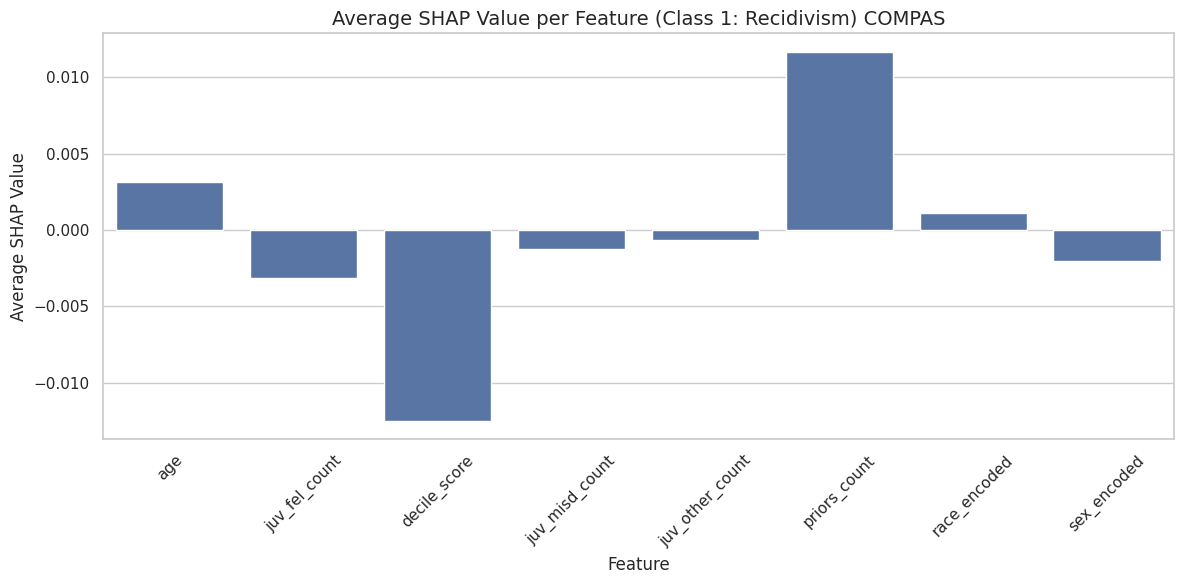

In [ ]:
#SHAP value for COMPAS_dataset
# Sample background data from training set
background = X_train_compas.sample(30, random_state=42)

# Initialize TreeExplainer with background data
explainer = shap.TreeExplainer(model_rf, data=background, model_output='probability')
shap_values = explainer.shap_values(X_test_compas)

# Extract the SHAP values for class 1 (Recidivism) for all samples
shap_values_class1 = np.array([sv[:, 1] for sv in shap_values])
print("SHAP values for class 1 shape:", shap_values_class1.shape)

# Convert the extracted SHAP values to a dataframe with the same columns as X_test_compas
shap_df_compas= pd.DataFrame(shap_values_class1, columns=X_test_compas.columns)
shap_df_compas['sample_id'] = shap_df_compas.index

# Melt the DataFrame into long format for plotting
shap_melted_compas= shap_df_compas.melt(id_vars='sample_id', var_name='feature', value_name='shap_value')

# Plot a bar plot of the SHAP values for each feature
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.barplot(x='feature', y='shap_value', data=shap_melted_compas, ci=None)

plt.title('Average SHAP Value per Feature (Class 1: Recidivism) COMPAS', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average SHAP Value', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#Use LIME Explainer
import random
from lime.lime_tabular import LimeTabularExplainer

# Create an instance
explainer = LimeTabularExplainer(
    training_data=np.array(X_train_compas),
    feature_names=X_train_compas.columns.tolist(),
    class_names=['No Recidivism', 'Recidivism'],
    mode='classification'
)
#List to collect data
lime_data=[]
# Loop through 30 random samples from X_test_compas
for i in random.sample(range(len(X_test_compas)), 30):
    exp = explainer.explain_instance(
        data_row=X_test_compas.iloc[i],
        predict_fn=model_rf.predict_proba,
        num_features=5
    )
    for feature,weight in exp.as_list():
        lime_data.append([i,feature,weight])

# Convert to DataFrame
lime_df = pd.DataFrame(lime_data, columns=['sample_id', 'feature', 'lime_weight'])



/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

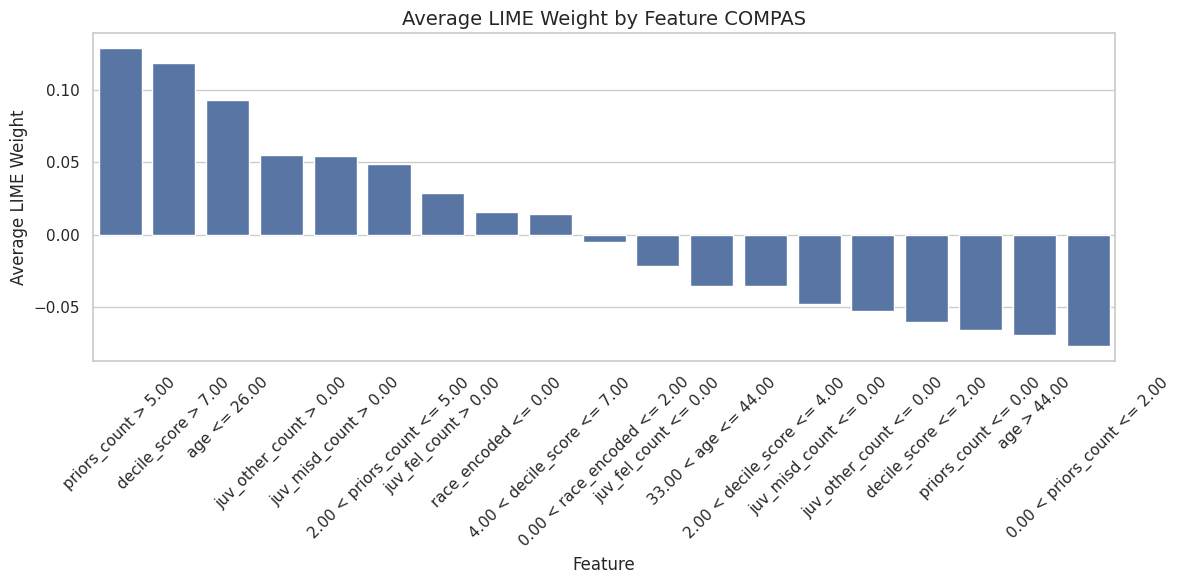

In [ ]:
#Make bar plot of Average LIME Weights(since we want to average it rather than making graaph for each local model)
#to visualize calculate the average LIME weight per feature
avg_weights_compas=lime_df.groupby('feature')['lime_weight'].mean().reset_index()
# sort by weight
avg_weights_compas=avg_weights_compas.sort_values(by='lime_weight',ascending=False)
#plot
plt.figure(figsize=(12,6))
sns.barplot(x='feature',y='lime_weight',data=avg_weights_compas)
plt.title('Average LIME Weight by Feature COMPAS', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average LIME Weight', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# 4. Reweighing for Class Imbalance and Retraining

# Calculate sample weights for the training data to help with class imbalance.
sample_weights = compute_sample_weight(class_weight='balanced', y=Y_train_compas)

# Initialize and train a Random Forest classifier with reweighing
rf_reweighted_compas = RandomForestClassifier(max_depth=3, random_state=42)
rf_reweighted_compas.fit(X_train_compas, Y_train_compas, sample_weight=sample_weights)

# Predict on the test set with the reweighted model
y_pred_rw_compas = rf_reweighted_compas.predict(X_test_compas)

print("\nReweighted Random Forest Model Performance:")
print(classification_report(Y_test_compas, y_pred_rw_compas))
print("Confusion Matrix:")
print(confusion_matrix(Y_test_compas, y_pred_rw_compas))

# Optionally, you can re-compute fairness metrics for the reweighted model:
X_test_compas_copy['pred'] = y_pred_rw_compas

print("\nFairness Metrics by Sex (Reweighted Model):")
metrics_by_sex_rw = {}
for sex in X_test_compas_copy['sex'].unique():
    metrics_by_sex_rw[sex] = compute_metrics(X_test_compas_copy, 'sex', sex)
    print(f"{sex}: {metrics_by_sex_rw[sex]}")

print("\nFairness Metrics by Race (Reweighted Model):")
metrics_by_race_rw = {}
for race in X_test_compas_copy['race'].unique():
    metrics_by_race_rw[race] = compute_metrics(X_test_compas_copy, 'race', race)
    print(f"{race}: {metrics_by_race_rw[race]}")


Reweighted Random Forest Model Performance:
              precision    recall  f1-score   support

           0       0.86      0.74      0.79       558
           1       0.36      0.54      0.43       149

    accuracy                           0.70       707
   macro avg       0.61      0.64      0.61       707
weighted avg       0.75      0.70      0.72       707

Confusion Matrix:
[[413 145]
 [ 69  80]]

Fairness Metrics by Sex (Reweighted Model):
Female: {'FPR': np.float64(0.12666666666666668), 'FNR': np.float64(0.7222222222222222), 'TNR': np.float64(0.8733333333333333), 'TPR': np.float64(0.2777777777777778)}
Male: {'FPR': np.float64(0.3088235294117647), 'FNR': np.float64(0.42748091603053434), 'TNR': np.float64(0.6911764705882353), 'TPR': np.float64(0.5725190839694656)}

Fairness Metrics by Race (Reweighted Model):
African-American: {'FPR': np.float64(0.39114391143911437), 'FNR': np.float64(0.33695652173913043), 'TNR': np.float64(0.6088560885608856), 'TPR': np.float64(0.66304347

In [ ]:
#Reweighing the class to improve the class imbalance for better prediction
# Calculate sample weights for class balance
sample_weights = compute_sample_weight(class_weight='balanced', y=Y_train_compas)

# Initialize Random Forest
rf_reweighted_compas = RandomForestClassifier(max_depth=3, random_state=42)

# Fit with reweighting
rf_reweighted_compas.fit(X_train_compas, Y_train_compas, sample_weight=sample_weights)

# Predict & evaluate
y_pred_rw_compas = rf_reweighted_compas.predict(X_test_compas)
print("Reweighted Random Forest Model:")
print(classification_report(Y_test_compas, y_pred_rw_compas))
print(confusion_matrix(Y_test_compas, y_pred_rw_compas))
#Load the reweighted model into a file
joblib.dump(rf_reweighted_compas,'rf_reweighted_compas.joblib')

Reweighted Random Forest Model:
              precision    recall  f1-score   support

           0       0.86      0.74      0.79       558
           1       0.36      0.54      0.43       149

    accuracy                           0.70       707
   macro avg       0.61      0.64      0.61       707
weighted avg       0.75      0.70      0.72       707

[[413 145]
 [ 69  80]]


['rf_reweighted_compas.joblib']

In [ ]:
import shap

# SHAP for reweighing
# Use background data comes from dataset as the test data
background_compas = X_train_compas.sample(30, random_state=42).astype(float)
X_test_compas_float = X_test_compas.astype(float)

# SHAP Explainer

explainer = shap.Explainer(rf_reweighted_compas, background_compas)
shap_values = explainer(X_test_compas_float)

# Extract SHAP values for class 1 (index 1)
shap_array = shap_values.values[:, :, 1]  # Shape: [707, 8]

# Create wide-format DataFrame
shap_df_compas = pd.DataFrame(shap_array, columns=X_test_compas.columns)

# Add sample IDs for reference
shap_df_compas['sample_id'] = shap_df_compas.index

# Save wide format CSV(this can be used with Phi-2)
shap_df_compas.to_csv("shap_values_compas_wide.csv", index=False)
print("SHAP values saved (wide format) to shap_values_compas_wide.csv")

# Melt to long format for bar plot or analysis
shap_melted_compas = shap_df_compas.melt(id_vars='sample_id', var_name='feature', value_name='shap_value')

# Save melted format CSV
shap_melted_compas.to_csv("shap_values_compas_long.csv", index=False)
print("SHAP values saved (long format) to shap_values_compas_long.csv")



SHAP values saved (wide format) to shap_values_compas_wide.csv
SHAP values saved (long format) to shap_values_compas_long.csv


<ipython-input-24-22f763e13d0a>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='feature', y='shap_value', data=shap_melted_compas, ci=None)


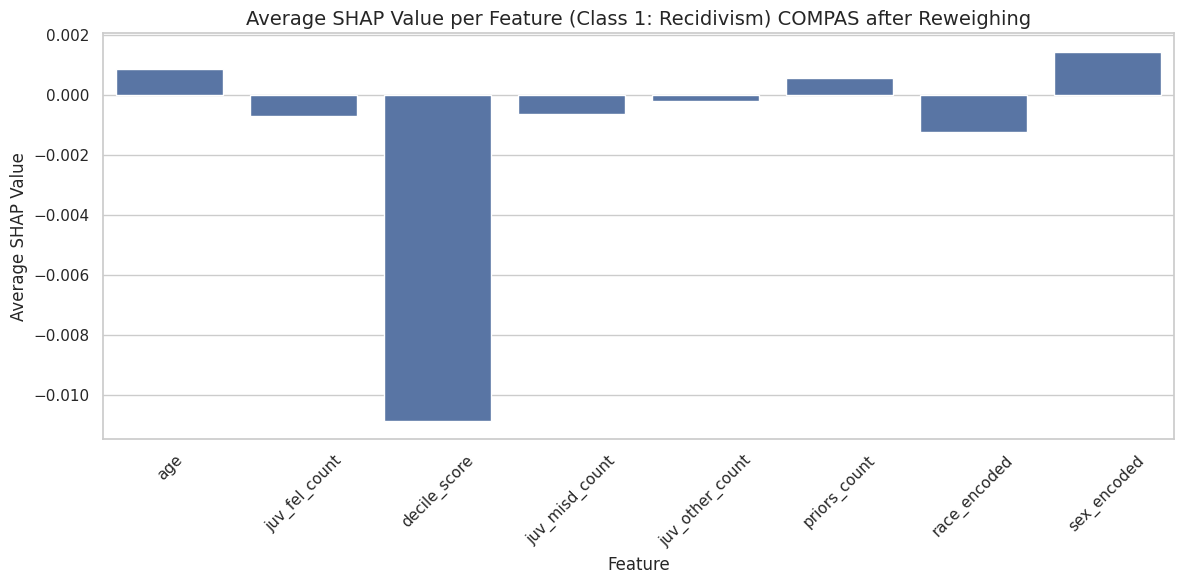

In [ ]:
# Plot a bar plot of the SHAP values for each feature
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.barplot(x='feature', y='shap_value', data=shap_melted_compas, ci=None)

plt.title('Average SHAP Value per Feature (Class 1: Recidivism) COMPAS after Reweighing', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average SHAP Value', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import random
from lime.lime_tabular import LimeTabularExplainer

# Create an instance for LIME Explainer
explainer = LimeTabularExplainer(
    training_data=np.array(X_train_compas),
    feature_names=X_train_compas.columns.tolist(),
    class_names=['No Recidivism', 'Recidivism'],
    mode='classification'
)
#List to collect data
lime_data=[]
# Loop through 30 random samples from X_test_compas
for i in random.sample(range(len(X_test_compas)), 30):
    exp = explainer.explain_instance(
        data_row=X_test_compas.iloc[i],
        predict_fn=model_rf.predict_proba,
        num_features=5
    )
    for feature,weight in exp.as_list():
        lime_data.append([i,feature,weight])

# Convert to DataFrame
lime_df = pd.DataFrame(lime_data, columns=['sample_id', 'feature', 'lime_weight'])
lime_df.to_csv("lime_values_compas.csv", index=False)
print("LIME values saved to lime_values_compas.csv")


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

LIME values saved to lime_values_compas.csv


/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

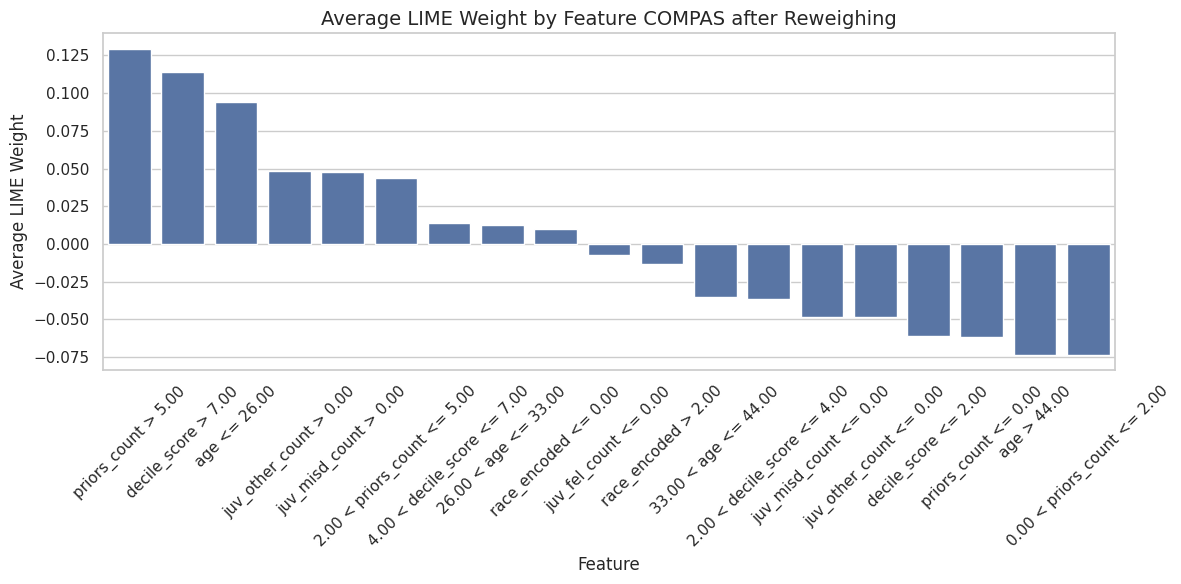

In [ ]:
#Make bar plot of Average LIME Weights for COMPAS
#calculate the average LIME weight per feature
avg_weights_compas=lime_df.groupby('feature')['lime_weight'].mean().reset_index()
# sort by weight
avg_weights_compas=avg_weights_compas.sort_values(by='lime_weight',ascending=False)
#plot
plt.figure(figsize=(12,6))
sns.barplot(x='feature',y='lime_weight',data=avg_weights_compas)
plt.title('Average LIME Weight by Feature COMPAS after Reweighing', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average LIME Weight', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import ttest_rel

# Let's do 5 repeated splits
n_splits = 5
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)

# Lists to store TPR values across splits
tpr_baseline_female_list = []
tpr_reweighted_female_list = []
tpr_baseline_African_American_list = []
tpr_reweighted_African_American_list = []

# Function to compute TPR for a subgroup from a DataFrame
def compute_tpr_for_group(model, df, sensitive_col, sensitive_value):
    # Make predictions using features only
    y_pred = model.predict(df.drop(columns=['two_year_recid', 'race', 'sex']))
    df_copy = df.copy()
    df_copy['pred'] = y_pred
    # Select the subgroup
    group = df_copy[df_copy[sensitive_col] == sensitive_value]
    TP = ((group['two_year_recid'] == 1) & (group['pred'] == 1)).sum()
    FN = ((group['two_year_recid'] == 1) & (group['pred'] == 0)).sum()
    return TP / (TP + FN) if (TP + FN) > 0 else np.nan

# Loop through repeated splits
for train_idx, test_idx in sss.split(df_compas_encoded, df_compas_encoded['two_year_recid']):
    df_train = df_compas_encoded.iloc[train_idx]
    df_test = df_compas_encoded.iloc[test_idx]

    # Extract features and target for training and testing
    X_train = df_train.drop(columns=['two_year_recid', 'race', 'sex'])
    y_train = df_train['two_year_recid']
    X_test = df_test.drop(columns=['two_year_recid', 'race', 'sex'])
    y_test = df_test['two_year_recid']

    # Baseline model
    model_baseline = RandomForestClassifier(random_state=42)
    model_baseline.fit(X_train, y_train)

    # Reweighted model (using sample weights)
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    model_reweighted = RandomForestClassifier(max_depth=3, random_state=42)
    model_reweighted.fit(X_train, y_train, sample_weight=sample_weights)

    # Create a temporary test DataFrame including sensitive attributes and true labels
    df_test_temp = X_test.copy()
    df_test_temp['two_year_recid'] = y_test
    df_test_temp['race'] = df_test['race']  # if race is present in df_test
    df_test_temp['sex'] = df_test['sex']    # if sex is present in df_test

    # Compute TPR for the "Female" group
    tpr_base_sex = compute_tpr_for_group(model_baseline, df_test_temp, sensitive_col="sex", sensitive_value="Female")
    tpr_rew_sex = compute_tpr_for_group(model_reweighted, df_test_temp, sensitive_col="sex", sensitive_value="Female")

    tpr_baseline_female_list.append(tpr_base_sex)
    tpr_reweighted_female_list.append(tpr_rew_sex)

    # Compute TPR for the "African-American" group
    tpr_base_race = compute_tpr_for_group(model_baseline, df_test_temp, sensitive_col="race", sensitive_value="African-American")
    tpr_rew_race = compute_tpr_for_group(model_reweighted, df_test_temp, sensitive_col="race", sensitive_value="African-American")

    tpr_baseline_African_American_list.append(tpr_base_race)
    tpr_reweighted_African_American_list.append(tpr_rew_race)

# Convert lists to numpy arrays
tpr_baseline_female = np.array(tpr_baseline_female_list)
tpr_reweighted_female = np.array(tpr_reweighted_female_list)
tpr_baseline_African_American = np.array(tpr_baseline_African_American_list)
tpr_reweighted_African_American = np.array(tpr_reweighted_African_American_list)

# Paired t-test for the Female group
t_stat_female, p_value_female = ttest_rel(tpr_reweighted_female, tpr_baseline_female)
print("Paired t-test for TPR in Female group:")
print("t-statistic: {:.3f}, p-value: {:.3f}".format(t_stat_female, p_value_female))
if p_value_female < 0.05:
    print("The improvement in TPR for females is statistically significant (p < 0.05).")
else:
    print("No statistically significant improvement in TPR for females (p >= 0.05).")

# Paired t-test for the African-American group
t_stat_race, p_value_race = ttest_rel(tpr_reweighted_African_American, tpr_baseline_African_American)
print("\nPaired t-test for TPR in African-American group:")
print("t-statistic: {:.3f}, p-value: {:.3f}".format(t_stat_race, p_value_race))
if p_value_race < 0.05:
    print("The improvement in TPR for African-American group is statistically significant (p < 0.05).")
else:
    print("No statistically significant improvement in TPR for African-American group (p >= 0.05).")


Paired t-test for TPR in Female group:
t-statistic: 7.408, p-value: 0.002
The improvement in TPR for females is statistically significant (p < 0.05).

Paired t-test for TPR in African-American group:
t-statistic: 24.958, p-value: 0.000
The improvement in TPR for African-American group is statistically significant (p < 0.05).


In [ ]:
#Apply SLM to reduce bias and also explain both prediction and bias after training in word
# Load tokenizer and phi-2 model
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2")
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2",
                                             torch_dtype=torch.float16,
                                             device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Check unique features
print("Unique features in the file:", shap_compas["feature"].unique())

# Adjust filter based on actual labels, e.g., if they are capitalized:
filtered_shap = shap_compas[shap_compas["feature"].isin(["Race", "Sex"])]

# Confirm that filtering returned rows
print("Filtered SHAP DataFrame shape:", filtered_shap.shape)


Unique features in the file: ['age' 'juv_fel_count' 'decile_score' 'juv_misd_count' 'juv_other_count'
 'priors_count' 'race_encoded' 'sex_encoded']
Filtered SHAP DataFrame shape: (0, 4)


In [ ]:
import pandas as pd

def generate_shap_prompt(feature, shap_value, prediction_label, dataset_name):
    """
    Generate a prompt for a SHAP explanation for one feature.
    """
    return (
        f"In the {dataset_name} dataset, the feature '{feature}' had a SHAP value of {shap_value:.2f}, "
        f"and the model predicted '{prediction_label}'. Explain in simple terms how this feature influenced the prediction, "
        f"and discuss whether it might reflect bias.\nExplanation:"
    )

def process_top_shap_features(df, dataset_name, output_csv_name, tokenizer, model, top_n=1):
    """
    Process a DataFrame of SHAP explanations to generate natural language explanations for the top features per instance.

    Parameters:
      df (pd.DataFrame): DataFrame containing at least the following columns:
                         "instance_id", "feature", "shap_value", "prediction_label"
      dataset_name (str): Name of the dataset (used for context in the prompt).
      output_csv_name (str): CSV filename to save the generated explanations.
      tokenizer: The tokenizer for your language model.
      model: The language model used to generate explanations.
      top_n (int): Number of top features to process per instance (default is 1).
    """
    explanations = []

    # Group the data by instance_id
    grouped = df.groupby("instance_id")

    for instance_id, group in grouped:
        # Select top_n features based on absolute SHAP value (i.e., most influential features)
        top_features = group.reindex(group["shap_value"].abs().sort_values(ascending=False).index)[:top_n]
        for idx, row in top_features.iterrows():
            try:
                prompt = generate_shap_prompt(
                    row["feature"], row["shap_value"], row["prediction_label"], dataset_name
                )
                inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
                outputs = model.generate(
                    **inputs,
                    max_length=150,
                    temperature=0.4,
                    top_p=0.9,
                    do_sample=True
                )
                full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
                explanation_only = full_output[len(prompt):].strip()

                explanations.append({
                    "instance_id": instance_id,
                    "feature": row["feature"],
                    "shap_value": row["shap_value"],
                    "prediction_label": row["prediction_label"],
                    "dataset": dataset_name,
                    "explanation": explanation_only
                })

                print(f"[{dataset_name}] Processed instance {instance_id} for feature '{row['feature']}'.")
            except Exception as e:
                print(f"Error processing instance {instance_id}, feature {row['feature']}: {e}")

    # Save the generated explanations to CSV
    results_df = pd.DataFrame(explanations)
    results_df.to_csv(output_csv_name, index=False)
    print(f"All top SHAP explanations saved to {output_csv_name}")

# Example usage:
# Load the CSV file with top SHAP features (ensure it includes "instance_id", "feature", "shap_value", "prediction_label")
shap_compas = pd.read_csv("shap_values_compas_long.csv")
shap_compas=shap_melted_compas.rename(columns={"sample_id": "instance_id"})
# Define your possible labels
possible_labels = ["Recidivism", "No Recidivism"]

# Assign a random label from the possible labels to each row
shap_compas["prediction_label"] = np.random.choice(possible_labels, size=len(shap_compas))

# Create an instance_id column if it doesn't exist
if "instance_id" not in shap_compas.columns:
    shap_compas["instance_id"] = shap_compas.index



# Process the entire SHAP DataFrame to generate explanations for all features.
process_top_shap_features(
    df=shap_compas.head(30),
    dataset_name="COMPAS",
    output_csv_name="shap_values_compas_all.csv",
    tokenizer=tokenizer,
    model=model,
    top_n=4
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 0 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 1 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 2 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 3 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 4 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 5 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 6 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 7 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 8 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 9 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 10 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 11 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 12 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 13 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 14 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 15 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 16 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 17 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 18 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 19 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 20 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 21 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 22 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 23 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 24 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 25 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 26 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 27 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 28 for feature 'age'.
[COMPAS] Processed instance 29 for feature 'age'.
All top SHAP explanations saved to shap_values_compas_all.csv


In [ ]:
print("Unique features:", shap_compas["feature"].unique())


Unique features: ['age' 'juv_fel_count' 'decile_score' 'juv_misd_count' 'juv_other_count'
 'priors_count' 'race_encoded' 'sex_encoded']


In [ ]:
# Define the sensitive features you want to focus on
sensitive_features = ["race_encoded", "sex_encoded"]

# Filter the DataFrame to include only rows where the feature is one of the sensitive features
sensitive_shap = shap_compas[shap_compas["feature"].isin(sensitive_features)].copy()

# Define your possible labels for binary outcomes
possible_labels = ["Recidivism", "No Recidivism"]

# Assign a random label from the possible labels to each row in the filtered DataFrame
sensitive_shap["prediction_label"] = np.random.choice(possible_labels, size=len(sensitive_shap))

# Process the filtered DataFrame to generate natural language explanations for sensitive features
process_top_shap_features(
    df=sensitive_shap.head(10),
    dataset_name="COMPAS",
    output_csv_name="shap_values_compas_sensitive.csv",
    tokenizer=tokenizer,
    model=model,
    top_n=3
)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 0 for feature 'race_encoded'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 1 for feature 'race_encoded'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 2 for feature 'race_encoded'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 3 for feature 'race_encoded'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 4 for feature 'race_encoded'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 5 for feature 'race_encoded'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 6 for feature 'race_encoded'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 7 for feature 'race_encoded'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 8 for feature 'race_encoded'.
[COMPAS] Processed instance 9 for feature 'race_encoded'.
All top SHAP explanations saved to shap_values_compas_sensitive.csv


In [ ]:
import pandas as pd


def generate_lime_prompt(feature, impact, prediction_label, dataset_name):
    """
    Generate a prompt for a LIME explanation for one feature.
    """
    return (
        f"In the {dataset_name} dataset, the feature '{feature}' had an impact score of {impact:.2f} "
        f"on the prediction '{prediction_label}'. Explain in simple terms how this feature influenced the prediction, "
        f"and discuss any potential bias associated with it.\nExplanation:"
    )

def process_top_lime_features(df, dataset_name, output_csv_name, tokenizer, model, top_n=1):
    """
    Process a DataFrame of LIME explanations to generate natural language explanations for the top features per instance.

    Parameters:
      df (pd.DataFrame): DataFrame containing at least the following columns:
                         "instance_id", "feature", "impact", "prediction_label"
      dataset_name (str): Name of the dataset (used for context in the prompt).
      output_csv_name (str): CSV filename to save the generated explanations.
      tokenizer: The tokenizer for your language model.
      model: The language model used to generate explanations.
      top_n (int): Number of top features to process per instance (default is 1).
    """
    explanations = []

    # Group the data by instance_id
    grouped = df.groupby("instance_id")

    for instance_id, group in grouped:
        # Select top_n features based on absolute impact value (i.e., most influential features)
        top_features = group.reindex(group["impact"].abs().sort_values(ascending=False).index)[:top_n]
        for idx, row in top_features.iterrows():
            try:
                prompt = generate_lime_prompt(
                    row["feature"], row["impact"], row["prediction_label"], dataset_name
                )
                inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
                outputs = model.generate(
                    **inputs,
                    max_length=150,
                    temperature=0.7,
                    top_p=0.9,
                    do_sample=True
                )
                full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
                explanation_only = full_output[len(prompt):].strip()

                explanations.append({
                    "instance_id": instance_id,
                    "feature": row["feature"],
                    "impact": row["impact"],
                    "prediction_label": row["prediction_label"],
                    "dataset": dataset_name,
                    "explanation": explanation_only
                })

                print(f"[{dataset_name}] Processed instance {instance_id} for feature '{row['feature']}'.")
            except Exception as e:
                print(f"Error processing instance {instance_id}, feature {row['feature']}: {e}")

    # Save the generated explanations to CSV
    results_df = pd.DataFrame(explanations)
    results_df.to_csv(output_csv_name, index=False)
    print(f"All top LIME explanations saved to {output_csv_name}")

# Example usage:
# Load the CSV file with LIME top features (ensure it includes "sample_id", "feature", "impact")
lime_compas = pd.read_csv("lime_values_compas.csv")
lime_compas = lime_compas.rename(columns={"sample_id": "instance_id", "lime_weight": "impact"})
# Rename 'sample_id' to 'instance_id'
lime_compas = lime_compas.rename(columns={"sample_id": "instance_id"})

# For testing purposes, add a dummy prediction_label (replace with actual predictions if available)
lime_compas["prediction_label"] = "Recidivism"

# Process a small sample (first 5 rows) to generate explanations
process_top_lime_features(
    df=lime_compas.head(10),
    dataset_name="COMPAS",
    output_csv_name="lime_values_compas_final.csv",
    tokenizer=tokenizer,
    model=model,
    top_n=3
)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 137 for feature 'age > 44.00'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 137 for feature 'decile_score <= 2.00'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 137 for feature 'priors_count <= 0.00'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 591 for feature 'priors_count <= 0.00'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 591 for feature 'decile_score <= 2.00'.
[COMPAS] Processed instance 591 for feature 'juv_misd_count <= 0.00'.
All top LIME explanations saved to lime_values_compas_final.csv


In [ ]:
#Load the adult dataset
df_adult = pd.read_csv('/content/drive/MyDrive/NCUR/adult.csv')
df_adult.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [ ]:
#Read the adult.csv file
df_adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [ ]:
df_adult.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
columns_to_drop_adult=['fnlwgt','capital-gain','capital-loss','native-country','education','relationship']
df_adult=df_adult.drop(columns=columns_to_drop_adult)

In [ ]:
#Check for duplicates before dropping it
df_adult.duplicated().sum()

np.int64(10364)

In [ ]:
#Drop the duplicates
df_adult = df_adult.drop_duplicates()
df_adult.duplicated().sum()

np.int64(0)

In [ ]:
df_adult.to_csv('cleaned_adult.csv',index=False)
df_adult_cleaned = df_adult.copy()

In [ ]:
df_adult_cleaned.info()
df_adult_cleaned.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
Index: 38478 entries, 0 to 48841
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              38478 non-null  int64 
 1   workclass        38478 non-null  object
 2   educational-num  38478 non-null  int64 
 3   marital-status   38478 non-null  object
 4   occupation       38478 non-null  object
 5   race             38478 non-null  object
 6   gender           38478 non-null  object
 7   hours-per-week   38478 non-null  int64 
 8   income           38478 non-null  object
dtypes: int64(3), object(6)
memory usage: 2.9+ MB


,age,workclass,educational-num,marital-status,occupation,race,gender,hours-per-week,income
count,38478.000000,38478,38478.000000,38478,38478,38478,38478,38478.000000,38478
unique,NaN,9,NaN,7,15,5,2,NaN,2
top,NaN,Private,NaN,Married-civ-spouse,Prof-specialty,White,Male,NaN,<=50K
freq,NaN,24833,NaN,17616,5213,31796,25311,NaN,29087
mean,40.034617,NaN,10.078902,NaN,NaN,NaN,NaN,40.701102,NaN
std,13.871053,NaN,2.706802,NaN,NaN,NaN,NaN,13.295617,NaN
min,17.000000,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN
25%,29.000000,NaN,9.000000,NaN,NaN,NaN,NaN,38.000000,NaN
50%,39.000000,NaN,10.000000,NaN,NaN,NaN,NaN,40.000000,NaN
75%,49.000000,NaN,13.000000,NaN,NaN,NaN,NaN,45.000000,NaN


In [ ]:
# Check for any '?' entries
for col in df_adult_cleaned.columns:
    print(f"{col}: {(df_adult_cleaned[col] == '?').sum()} ")
# Count '?' in workclass and occupation by gender
for col in ['workclass', 'occupation']:
    # Filter the DataFrame for rows where the specified column has '?'
    missing_rows = df_adult_cleaned[df_adult_cleaned[col] == '?']
    # Get the value counts of 'gender' in the filtered rows
    missing_by_gender = missing_rows['gender'].value_counts()
    print(f"\nMissing '{col}' entries by gender:\n{missing_by_gender}")


age: 0 
workclass: 2234 
educational-num: 0 
marital-status: 0 
occupation: 2244 
race: 0 
gender: 0 
hours-per-week: 0 
income: 0 

Missing 'workclass' entries by gender:
gender
Male      1212
Female    1022
Name: count, dtype: int64

Missing 'occupation' entries by gender:
gender
Male      1219
Female    1025
Name: count, dtype: int64


In [ ]:
#Drop the workclass and occupation columns since the difference is negligible in gender
columns_to_drop_adult=['workclass','occupation']
df_adult_cleaned=df_adult_cleaned.drop(columns=columns_to_drop_adult)
print(df_adult_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 38478 entries, 0 to 48841
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              38478 non-null  int64 
 1   educational-num  38478 non-null  int64 
 2   marital-status   38478 non-null  object
 3   race             38478 non-null  object
 4   gender           38478 non-null  object
 5   hours-per-week   38478 non-null  int64 
 6   income           38478 non-null  object
dtypes: int64(3), object(4)
memory usage: 2.3+ MB
None


In [ ]:
#Encoding the adult dataset next
#Make a copy of the cleaned adult
df_adult_cleaned=df_adult_cleaned.copy()

#map the encoding to use fairness analysis

gender_mapping={'Female':0,'Male':1}
income_mapping={'<=50K':0,'>50K':1}

race_mapping_adult = {
    'Black': 0,
    'White': 1,
    'Asian-Pac-Islander': 2,
    'Amer-Indian-Eskimo': 3,
    'Other': 4
}

df_adult_cleaned['gender_encoded']=df_adult_cleaned['gender'].map(gender_mapping)
df_adult_cleaned['income_encoded']=df_adult_cleaned['income'].map(income_mapping)
df_adult_cleaned['race_encoded']=df_adult_cleaned['race'].map(race_mapping_adult)

#One-Hot Encoding multi-class categorical columns
df_adult_cleaned=pd.get_dummies(df_adult_cleaned,columns=['marital-status'])

df_adult_cleaned.to_csv('adult_encoded.csv', index=False)
df_adult_encoded = df_adult_cleaned.copy()
df_adult_encoded.head()

,age,educational-num,race,gender,hours-per-week,income,gender_encoded,income_encoded,race_encoded,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed
0,25,7,Black,Male,40,<=50K,1,0,0,False,False,False,False,True,False,False
1,38,9,White,Male,50,<=50K,1,0,1,False,False,True,False,False,False,False
2,28,12,White,Male,40,>50K,1,1,1,False,False,True,False,False,False,False
3,44,10,Black,Male,40,>50K,1,1,0,False,False,True,False,False,False,False
4,18,10,White,Female,30,<=50K,0,0,1,False,False,False,False,True,False,False


In [ ]:
#Check if they are actually encoded or not
df_adult_encoded['gender_encoded'].unique()

array([1, 0])

In [ ]:
df_adult_encoded['income_encoded'].unique()

array([0, 1])

In [ ]:
df_adult_encoded['race_encoded'].unique()

array([0, 1, 2, 4, 3])

In [ ]:
#Split the dataset into to train and test split then train
#Perform logisitc regression on adult dataset
X_adult=df_adult_encoded.drop(columns=['income','race','gender','income_encoded'])
Y_adult=df_adult_encoded['income_encoded']
X_train_adult,X_test_adult,Y_train_adult,Y_test_adult=train_test_split(X_adult,Y_adult,test_size=0.2,random_state=42)
model_lr=LogisticRegression(max_iter=1000)
model_lr.fit(X_train_adult,Y_train_adult)
y_pred_lg=model_lr.predict(X_test_adult)

In [ ]:
#Evaluate the performance
print(classification_report(Y_test_adult,y_pred_lg))
print(confusion_matrix(Y_test_adult,y_pred_lg))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      5813
           1       0.65      0.45      0.53      1883

    accuracy                           0.80      7696
   macro avg       0.74      0.68      0.70      7696
weighted avg       0.79      0.80      0.79      7696

[[5352  461]
 [1042  841]]


In [ ]:
#Train the model with XGBoost Classifier
X_adult=df_adult_encoded.drop(columns=['income','race','gender','income_encoded'])
Y_adult=df_adult_encoded['income_encoded']
X_train_adult,X_test_adult,Y_train_adult,Y_test_adult=train_test_split(X_adult,Y_adult,test_size=0.2,random_state=42)
model_xg=XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, random_state=42)
model_xg.fit(X_train_adult,Y_train_adult)
y_pred_xg=model_xg.predict(X_test_adult)

In [ ]:
#Evaluate the performance fo xg booster
print(classification_report(Y_test_adult,y_pred_xg))
print(confusion_matrix(Y_test_adult,y_pred_xg))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89      5813
           1       0.68      0.50      0.58      1883

    accuracy                           0.82      7696
   macro avg       0.76      0.71      0.73      7696
weighted avg       0.81      0.82      0.81      7696

[[5356  457]
 [ 933  950]]


In [ ]:
import pandas as pd

def compute_metrics(df, sensitive_column, sensitive_value):
    """
    Compute fairness metrics for a subgroup.
    """
    group = df[df[sensitive_column] == sensitive_value]

    # Calculate confusion matrix components
    TP = ((group['true'] == 1) & (group['pred'] == 1)).sum()
    TN = ((group['true'] == 0) & (group['pred'] == 0)).sum()
    FP = ((group['true'] == 0) & (group['pred'] == 1)).sum()
    FN = ((group['true'] == 1) & (group['pred'] == 0)).sum()

    # Calculate metrics with checks to avoid division by zero
    fpr = FP / (FP + TN) if (FP + TN) > 0 else None
    fnr = FN / (FN + TP) if (FN + TP) > 0 else None
    tnr = TN / (TN + FP) if (TN + FP) > 0 else None
    tpr = TP / (TP + FN) if (TP + FN) > 0 else None

    return {'FPR': fpr, 'FNR': fnr, 'TNR': tnr, 'TPR': tpr}

# Prepare the Adult test set with sensitive attributes

# Create a copy of the test features
X_test_adult_copy = X_test_adult.copy()

# Attach the true labels and model predictions
X_test_adult_copy['true'] = Y_test_adult
X_test_adult_copy['pred'] = y_pred_xg

# Re-attach sensitive attributes (assume df_adult_cleaned holds these for the same indices)
X_test_adult_copy['race'] = df_adult_cleaned.loc[X_test_adult.index, 'race']
X_test_adult_copy['gender'] = df_adult_cleaned.loc[X_test_adult.index, 'gender']

# Compute fairness metrics for each subgroup by gender
print("Fairness Metrics by Gender:")
gender_groups = X_test_adult_copy['gender'].unique()
metrics_by_gender = {}
for gender in gender_groups:
    metrics_by_gender[gender] = compute_metrics(X_test_adult_copy, 'gender', gender)
    print(f"{gender}: {metrics_by_gender[gender]}")

# Compute fairness metrics for each subgroup by race
print("\nFairness Metrics by Race:")
race_groups = X_test_adult_copy['race'].unique()
metrics_by_race = {}
for race in race_groups:
    metrics_by_race[race] = compute_metrics(X_test_adult_copy, 'race', race)
    print(f"{race}: {metrics_by_race[race]}")

# Additional Analysis: Proportions of errors by race
fp_by_race = X_test_adult_copy[(X_test_adult_copy['true'] == 0) & (X_test_adult_copy['pred'] == 1)]['race'].value_counts(normalize=True)
fn_by_race = X_test_adult_copy[(X_test_adult_copy['true'] == 1) & (X_test_adult_copy['pred'] == 0)]['race'].value_counts(normalize=True)

print("\nFalse Positives by Race (Proportion):")
print(fp_by_race)
print("\nFalse Negatives by Race (Proportion):")
print(fn_by_race)

# Similarly, for gender:
fp_by_gender = X_test_adult_copy[(X_test_adult_copy['true'] == 0) & (X_test_adult_copy['pred'] == 1)]['gender'].value_counts(normalize=True)
fn_by_gender = X_test_adult_copy[(X_test_adult_copy['true'] == 1) & (X_test_adult_copy['pred'] == 0)]['gender'].value_counts(normalize=True)

print("\nFalse Positives by Gender (Proportion):")
print(fp_by_gender)
print("\nFalse Negatives by Gender (Proportion):")
print(fn_by_gender)


Fairness Metrics by Gender:
Female: {'FPR': np.float64(0.021285653469561516), 'FNR': np.float64(0.5933147632311978), 'TNR': np.float64(0.9787143465304385), 'TPR': np.float64(0.40668523676880225)}
Male: {'FPR': np.float64(0.11749422632794457), 'FNR': np.float64(0.47244094488188976), 'TNR': np.float64(0.8825057736720554), 'TPR': np.float64(0.5275590551181102)}

Fairness Metrics by Race:
White: {'FPR': np.float64(0.09244596618874384), 'FNR': np.float64(0.4892729439809297), 'TNR': np.float64(0.9075540338112561), 'TPR': np.float64(0.5107270560190703)}
Black: {'FPR': np.float64(0.014588859416445624), 'FNR': np.float64(0.5789473684210527), 'TNR': np.float64(0.9854111405835544), 'TPR': np.float64(0.42105263157894735)}
Asian-Pac-Islander: {'FPR': np.float64(0.06363636363636363), 'FNR': np.float64(0.4520547945205479), 'TNR': np.float64(0.9363636363636364), 'TPR': np.float64(0.547945205479452)}
Amer-Indian-Eskimo: {'FPR': np.float64(0.0), 'FNR': np.float64(0.7), 'TNR': np.float64(1.0), 'TPR': np.

(7696, 12)
(12,)


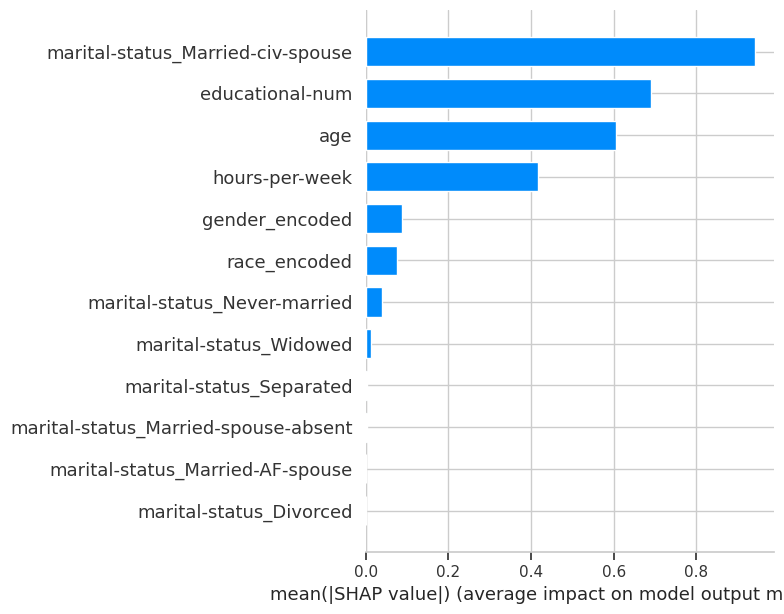

In [105]:
#Work on the SHAP values for the adult dataset
# Sample background data
background_adult = X_train_adult.sample(30, random_state=42).astype(float)
X_test_adult_float = X_test_adult.astype(float)

# Initialize SHAP Explainer (auto-detect TreeExplainer)
explainer = shap.Explainer(model_xg, background_adult)

# Compute SHAP values (returns Explanation object)
shap_values = explainer(X_test_adult_float)

# Extract SHAP values (shape: n_samples x n_features)
shap_values_class1_adult = shap_values.values

# Confirm shapes match for DataFrame
print(shap_values_class1_adult.shape)
print(X_test_adult.columns.shape)

# Convert to DataFrame
shap_df_adult = pd.DataFrame(shap_values_class1_adult, columns=X_test_adult.columns)
shap_df_adult['sample_id'] = shap_df_adult.index

# Melt for seaborn plot
shap_melted_adult = shap_df_adult.melt(id_vars='sample_id', var_name='feature', value_name='shap_value')
# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_adult, plot_type="bar", show=True)


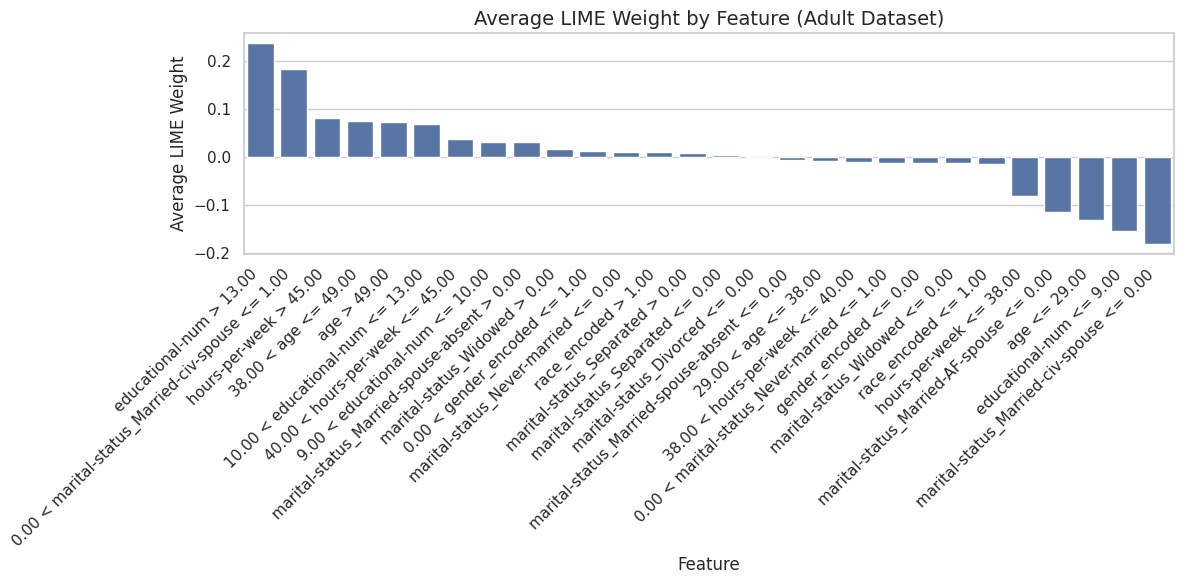

In [106]:
#Apply the LIME for adult dataset too
# Convert to numpy arrays
X_train_np = X_train_adult.values
X_test_np = X_test_adult.values
feature_names = X_train_adult.columns.tolist()
class_names = ['<=50K', '>50K']

# Initialize LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True
)

# All the LIME weights into a list
lime_weights_list = []

# Loop over samples from test set
N = 30
for i in range(N):
    exp = explainer.explain_instance(
        data_row=X_test_np[i],
        predict_fn=model_xg.predict_proba,
        num_features=10
    )

    # Get explanation
    for feature, weight in exp.as_list():
        lime_weights_list.append({'feature': feature, 'lime_weight': weight})

# Convert to DataFrame
lime_df = pd.DataFrame(lime_weights_list)

# Group by feature and calculate average weight
avg_weights_adult = lime_df.groupby('feature')['lime_weight'].mean().reset_index()
avg_weights_adult = avg_weights_adult.sort_values(by='lime_weight', ascending=False)

# Plot average LIME weight per feature
plt.figure(figsize=(12, 6))
sns.barplot(x='feature', y='lime_weight', data=avg_weights_adult)
plt.title('Average LIME Weight by Feature (Adult Dataset)', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Average LIME Weight', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [107]:
#Reweighing for the ADULT dataset
# Calculate sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=Y_train_adult)

# Fit model with sample weights
model_xg_reweighted = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, random_state=42)
model_xg_reweighted.fit(X_train_adult, Y_train_adult, sample_weight=sample_weights)

# Predict and Evaluate
y_pred_rw_adult = model_xg_reweighted.predict(X_test_adult)
print("Reweighted Model for Adult dataset:")
print(classification_report(Y_test_adult, y_pred_rw_adult))
print("Confusion Matrix:")
print(confusion_matrix(Y_test_adult, y_pred_rw_adult))

# Optionally, you can re-compute fairness metrics for the reweighted model:
X_test_adult_copy['pred'] = y_pred_rw_adult

print("\nFairness Metrics by Gender (Reweighted Model):")
metrics_by_gender_rw = {}
for sex in X_test_adult_copy['gender'].unique():
    metrics_by_gender_rw[gender] = compute_metrics(X_test_adult_copy, 'gender', gender)
    print(f"{gender}: {metrics_by_gender_rw[gender]}")

print("\nFairness Metrics by Race (Reweighted Model):")
metrics_by_race_rw = {}
for race in X_test_adult_copy['race'].unique():
    metrics_by_race_rw[race] = compute_metrics(X_test_adult_copy, 'race', race)
    print(f"{race}: {metrics_by_race_rw[race]}")

Reweighted Model for Adult dataset:
              precision    recall  f1-score   support

           0       0.93      0.75      0.83      5813
           1       0.51      0.83      0.63      1883

    accuracy                           0.77      7696
   macro avg       0.72      0.79      0.73      7696
weighted avg       0.83      0.77      0.78      7696

Confusion Matrix:
[[4340 1473]
 [ 324 1559]]

Fairness Metrics by Gender (Reweighted Model):
Male: {'FPR': np.float64(0.35767898383371827), 'FNR': np.float64(0.14173228346456693), 'TNR': np.float64(0.6423210161662818), 'TPR': np.float64(0.8582677165354331)}
Male: {'FPR': np.float64(0.35767898383371827), 'FNR': np.float64(0.14173228346456693), 'TNR': np.float64(0.6423210161662818), 'TPR': np.float64(0.8582677165354331)}

Fairness Metrics by Race (Reweighted Model):
White: {'FPR': np.float64(0.2841857479135459), 'FNR': np.float64(0.16686531585220502), 'TNR': np.float64(0.7158142520864541), 'TPR': np.float64(0.833134684147795)}
Blac

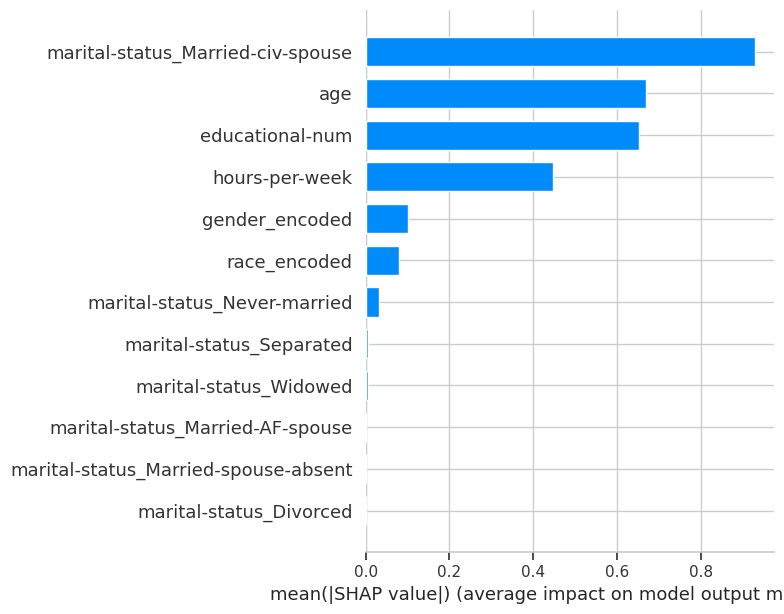

In [108]:
#SHAP after reweighing the values for Adult dataset

# Background for SHAP
background_adult = X_train_adult.sample(50, random_state=42).astype(float)
X_test_adult_float = X_test_adult.astype(float)

# SHAP Explainer after Reweighing
explainer = shap.Explainer(model_xg_reweighted, background_adult)
shap_values = explainer(X_test_adult_float)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_test_adult, plot_type="bar", show=True)


In [109]:
#Save reweighted SHAP values in dataframe then csv for later
import pandas as pd

# Extract SHAP values (matrix)
shap_array = shap_values.values  # shape: [num_samples, num_features]

# Convert to DataFrame with feature names
shap_df = pd.DataFrame(shap_array, columns=X_test_adult.columns)

# Optional: Add prediction and true labels for context
shap_df["prediction"] = model_xg_reweighted.predict(X_test_adult)
shap_df["true_label"] = Y_test_adult.values
#Convert it to csv
shap_df.to_csv("shap_values_adult.csv", index=False)
print("SHAP values saved to shap_values_adult.csv")


SHAP values saved to shap_values_adult.csv


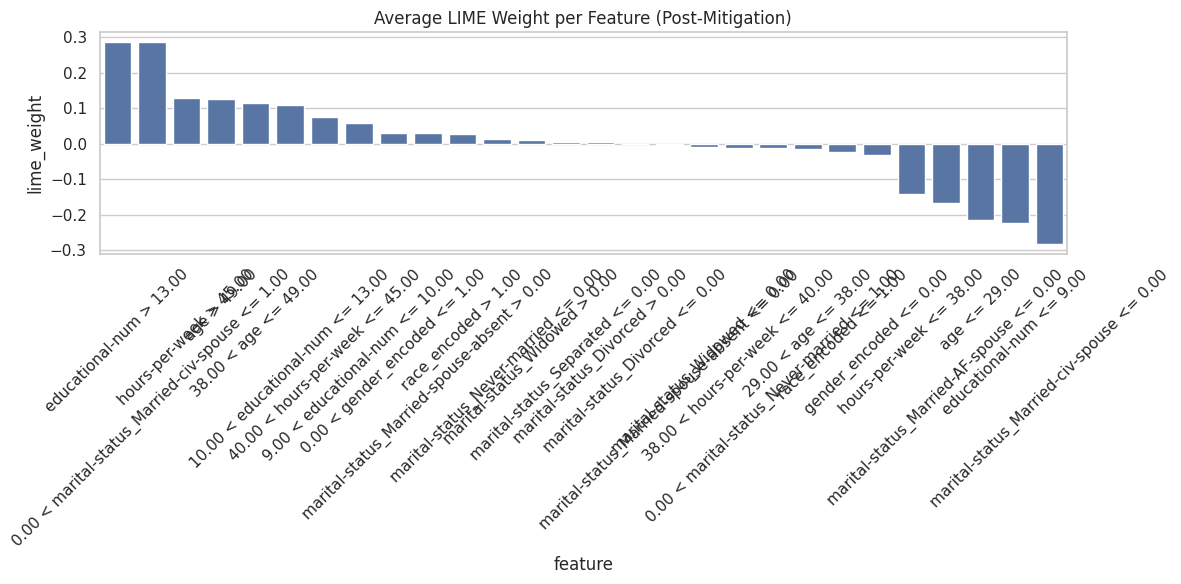

In [110]:
#LIME after reweighing
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_adult.values,
    feature_names=X_train_adult.columns.tolist(),
    class_names=['<=50K', '>50K'],
    mode='classification'
)

lime_weights = []
for i in range(30):
    exp = explainer.explain_instance(
        data_row=X_test_adult.values[i],
        predict_fn=model_xg_reweighted.predict_proba,
        num_features=10
    )
    for feature, weight in exp.as_list():
        lime_weights.append({'feature': feature, 'lime_weight': weight})

lime_df = pd.DataFrame(lime_weights)
avg_weights = lime_df.groupby('feature')['lime_weight'].mean().reset_index()

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.barplot(x='feature', y='lime_weight', data=avg_weights.sort_values('lime_weight', ascending=False))
plt.title('Average LIME Weight per Feature (Post-Mitigation)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [128]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import ttest_rel
import numpy as np
from xgboost import XGBClassifier  # ensure you have imported your classifier

# Let's do 5 repeated splits
n_splits = 5
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=42)

# Lists to store TPR values across splits
tpr_baseline_female_list = []
tpr_reweighted_female_list = []
tpr_baseline_Black_list = []
tpr_reweighted_Black_list = []

# Function to compute TPR for a subgroup from a DataFrame
def compute_tpr_for_group_adult(model, df, sensitive_col, sensitive_value):
    # Make predictions using features only (drop columns not used by the model)
    y_pred = model.predict(df.drop(columns=['income', 'race', 'gender']))
    # Create a copy to avoid modifying the original DataFrame
    df_copy = df.copy()
    df_copy['pred'] = y_pred
    # Select the subgroup based on the sensitive attribute
    group = df_copy[df_copy[sensitive_col] == sensitive_value]

    # Debug: Print number of positive cases in the subgroup
    pos_count = (group['income'] == 1).sum()
    print(f"{sensitive_value} positive count: {pos_count}")

    TP = ((group['income'] == 1) & (group['pred'] == 1)).sum()
    FN = ((group['income'] == 1) & (group['pred'] == 0)).sum()
    return TP / (TP + FN) if (TP + FN) > 0 else np.nan

# Loop through repeated splits
for train_idx, test_idx in sss.split(df_adult_encoded, df_adult_encoded['income']):
    df_train = df_adult_encoded.iloc[train_idx]
    df_test = df_adult_encoded.iloc[test_idx]

    # Extract features and target for training and testing
    X_train = df_train.drop(columns=['income', 'race', 'gender'])
    y_train = df_train['income_encoded']  # Assuming this is the numeric encoding of income
    X_test = df_test.drop(columns=['income', 'race', 'gender'])
    y_test = df_test['income_encoded']

    # Baseline model training
    model_baseline = XGBClassifier(random_state=42)
    model_baseline.fit(X_train, y_train)

    # Reweighted model training using sample weights
    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
    model_reweighted = XGBClassifier(max_depth=3, random_state=42)
    model_reweighted.fit(X_train, y_train, sample_weight=sample_weights)

    # Create a temporary test DataFrame including sensitive attributes and true labels
    df_test_temp = X_test.copy()
    df_test_temp['income'] = y_test  # Note: this column is used as the true label
    df_test_temp['race'] = df_test['race']
    df_test_temp['gender'] = df_test['gender']

    # Compute TPR for the "Female" group
    tpr_base_gender = compute_tpr_for_group_adult(model_baseline, df_test_temp, sensitive_col="gender", sensitive_value="Female")
    tpr_rew_gender = compute_tpr_for_group_adult(model_reweighted, df_test_temp, sensitive_col="gender", sensitive_value="Female")

    tpr_baseline_female_list.append(tpr_base_gender)
    tpr_reweighted_female_list.append(tpr_rew_gender)

    # Compute TPR for the "Black" group
    tpr_base_race = compute_tpr_for_group_adult(model_baseline, df_test_temp, sensitive_col="race", sensitive_value="Black")
    tpr_rew_race = compute_tpr_for_group_adult(model_reweighted, df_test_temp, sensitive_col="race", sensitive_value="Black")

    tpr_baseline_Black_list.append(tpr_base_race)
    tpr_reweighted_Black_list.append(tpr_rew_race)

# Convert lists to numpy arrays
tpr_baseline_female = np.array(tpr_baseline_female_list)
tpr_reweighted_female = np.array(tpr_reweighted_female_list)
tpr_baseline_Black = np.array(tpr_baseline_Black_list)
tpr_reweighted_Black = np.array(tpr_reweighted_Black_list)

# Paired t-test for the Female group
t_stat_female, p_value_female = ttest_rel(tpr_reweighted_female, tpr_baseline_female)
print("Paired t-test for TPR in Female group:")
print("t-statistic: {:.3f}, p-value: {:.3f}".format(t_stat_female, p_value_female))
if p_value_female < 0.05:
    print("The improvement in TPR for females is statistically significant (p < 0.05).")
else:
    print("No statistically significant improvement in TPR for females (p >= 0.05).")

# Paired t-test for the Black group
t_stat_race, p_value_race = ttest_rel(tpr_reweighted_Black, tpr_baseline_Black)
print("\nPaired t-test for TPR in Black group:")
print("t-statistic: {:.3f}, p-value: {:.3f}".format(t_stat_race, p_value_race))
if p_value_race < 0.05:
    print("The improvement in TPR for Black group is statistically significant (p < 0.05).")
else:
    print("No statistically significant improvement in TPR for Black group (p >= 0.05).")


Female positive count: 331
Female positive count: 331
Black positive count: 113
Black positive count: 113
Female positive count: 326
Female positive count: 326
Black positive count: 128
Black positive count: 128
Female positive count: 320
Female positive count: 320
Black positive count: 97
Black positive count: 97
Female positive count: 325
Female positive count: 325
Black positive count: 104
Black positive count: 104
Female positive count: 306
Female positive count: 306
Black positive count: 106
Black positive count: 106
Paired t-test for TPR in Female group:
t-statistic: nan, p-value: nan
No statistically significant improvement in TPR for females (p >= 0.05).

Paired t-test for TPR in Black group:
t-statistic: nan, p-value: nan
No statistically significant improvement in TPR for Black group (p >= 0.05).


In [134]:
print("Columns in shap_adult:", shap_adult.columns)


Columns in shap_adult: Index(['age', 'educational-num', 'hours-per-week', 'gender_encoded',
       'race_encoded', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed', 'prediction',
       'true_label', 'prediction_label', 'instance_id'],
      dtype='object')


In [142]:
import pandas as pd
import numpy as np

# Load your wide-format CSV file
shap_adult = pd.read_csv("shap_values_adult.csv")

# Check the columns before renaming
print("Columns before renaming:", shap_adult.columns)

# Rename 'sample_id' to 'instance_id' if it exists
if "sample_id" in shap_adult.columns:
    shap_adult = shap_adult.rename(columns={"sample_id": "instance_id"})

# If 'instance_id' still does not exist, create it from the index
if "instance_id" not in shap_adult.columns:
    shap_adult["instance_id"] = shap_adult.index

# (Optional) If you want to assign random prediction labels for testing:
possible_labels = ["Income>=50k", "Income<=50k"]
shap_adult["prediction_label"] = np.random.choice(possible_labels, size=len(shap_adult))

# Define id_vars for the melt operation. Adjust these if needed.
id_vars = ["instance_id", "prediction", "true_label", "prediction_label"]

# Identify feature columns by excluding id_vars.
feature_columns = [col for col in shap_adult.columns if col not in id_vars]

# Melt the DataFrame: this creates two new columns "feature" and "shap_value"
melted_shap_adult = shap_adult.melt(
    id_vars=["instance_id", "prediction_label"],
    value_vars=feature_columns,
    var_name="feature",
    value_name="shap_value"
)

# Check the result
print("Melted DataFrame columns:", melted_shap_adult.columns)
print(melted_shap_adult.head())

# Now you can call your process_top_shap_features function on a subset (e.g., first 30 rows)
process_top_shap_features(
    df=melted_shap_adult.head(30),
    dataset_name="Adult",
    output_csv_name="shap_values_adult_all.csv",
    tokenizer=tokenizer,  # ensure your tokenizer is loaded
    model=model,          # ensure your model is loaded
    top_n=4
)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Columns before renaming: Index(['age', 'educational-num', 'hours-per-week', 'gender_encoded',
       'race_encoded', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed', 'prediction',
       'true_label'],
      dtype='object')
Melted DataFrame columns: Index(['instance_id', 'prediction_label', 'feature', 'shap_value'], dtype='object')
   instance_id prediction_label feature  shap_value
0            0      Income<=50k     age   -1.721075
1            1      Income<=50k     age    0.510381
2            2      Income>=50k     age    0.644516
3            3      Income>=50k     age   -0.752209
4            4      Income<=50k     age   -1.655172


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 0 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 1 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 2 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 3 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 4 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 5 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 6 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 7 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 8 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 9 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 10 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 11 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 12 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 13 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 14 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 15 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 16 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 17 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 18 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 19 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 20 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 21 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 22 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 23 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 24 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 25 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 26 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 27 for feature 'age'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[Adult] Processed instance 28 for feature 'age'.
[Adult] Processed instance 29 for feature 'age'.
All top SHAP explanations saved to shap_values_adult_all.csv


In [144]:

# Define the sensitive features you want to focus on
sensitive_features = ["race_encoded", "gender_encoded"]

# Filter the DataFrame to include only rows where the feature is one of the sensitive features
sensitive_shap = shap_compas[shap_compas["feature"].isin(sensitive_features)].copy()

# Define your possible labels for binary outcomes
possible_labels = ["Income>=50k", "Income<=50k"]

# Assign a random label from the possible labels to each row in the filtered DataFrame
sensitive_shap["prediction_label"] = np.random.choice(possible_labels, size=len(sensitive_shap))

# Process the filtered DataFrame to generate natural language explanations for sensitive features
process_top_shap_features(
    df=sensitive_shap.head(10),
    dataset_name="COMPAS",
    output_csv_name="shap_values_adult_sensitive.csv",
    tokenizer=tokenizer,
    model=model,
    top_n=3
)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 0 for feature 'race_encoded'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 1 for feature 'race_encoded'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 2 for feature 'race_encoded'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 3 for feature 'race_encoded'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 4 for feature 'race_encoded'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 5 for feature 'race_encoded'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 6 for feature 'race_encoded'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 7 for feature 'race_encoded'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 8 for feature 'race_encoded'.
[COMPAS] Processed instance 9 for feature 'race_encoded'.
All top SHAP explanations saved to shap_values_adult_sensitive.csv


In [146]:
# Load the CSV file with LIME top features (ensure it includes "sample_id", "feature", "impact")
lime_compas = pd.read_csv("lime_values_compas.csv")
lime_compas = lime_compas.rename(columns={"sample_id": "instance_id", "lime_weight": "impact"})
# Rename 'sample_id' to 'instance_id'
lime_compas = lime_compas.rename(columns={"sample_id": "instance_id"})


# For testing purposes, add a dummy prediction_label (replace with actual predictions if available)

# Define your possible labels for binary outcomes
possible_labels = ["Income>=50k", "Income<=50k"]

# Assign a random label from the possible labels to each row in the filtered DataFrame
lime_compas["prediction_label"] = np.random.choice(possible_labels, size=len(lime_compas))


# Process a small sample (first 5 rows) to generate explanations
process_top_lime_features(
    df=lime_compas.head(10),
    dataset_name="COMPAS",
    output_csv_name="lime_values_compas_final.csv",
    tokenizer=tokenizer,
    model=model,
    top_n=3
)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 137 for feature 'age > 44.00'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 137 for feature 'decile_score <= 2.00'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 137 for feature 'priors_count <= 0.00'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 591 for feature 'priors_count <= 0.00'.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[COMPAS] Processed instance 591 for feature 'decile_score <= 2.00'.
[COMPAS] Processed instance 591 for feature 'juv_misd_count <= 0.00'.
All top LIME explanations saved to lime_values_compas_final.csv
